### Paul Adams
### DS7337 Natural Language Processing
### Homework 3
### June 7, 2020

In [5]:
# Load infrastructure
import os
import re
import numpy
import keras
import spacy
import pathlib
import pandas as pd
from sklearn.utils import shuffle
#from pycontractions import Contractions
from gensim.parsing.preprocessing import strip_punctuation, remove_stopwords

# Load data
!python3 -m spacy download en_core_web_lg
import en_core_web_lg

# Load Neural Nets
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import  LSTM as LSTM, SimpleRNN, GRU
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

# Load visualization tool
import matplotlib.pyplot as plt

# fix random seed for reproducibility
numpy.random.seed(7)

# display 400 characters of column width
pd.options.display.max_colwidth = 400

#Reference Material:
#https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [6]:
# Load infrastructure
import os
import re
import numpy

import pathlib
import pandas as pd
from sklearn.utils import shuffle


In [9]:
os.getcwd()

'/home/pablo/Desktop/DS7337 Natural Language Processing/HW3'

In [ ]:
os.chdir('~/Desktop/DS7337 Natural Language Processing/HW3')

## Function to load the data

In [7]:
def load_df():
    """ loads data as dataframe """
    path = pathlib.Path.cwd() / "sentiment labelled sentences"
    paths = path.iterdir()
    df  = pd.DataFrame()
   
    for i, path in enumerate(paths):
        if path.stem == 'readme':
            continue # if the path in the directory is to the readme file, skip to the next file
        data = pd.read_csv(path, sep = r'\t', header=  None) # tab separated so split at tabs to create the columns
        df = pd.concat([data, df], axis = 0, ignore_index = True)
        df.reset_index()
    return df

In [ ]:
df1 = load_df()

## Function to remove special characters, replacing hyphens and underscores with spaces to split joined words into two usable words (rather than one combined non-word concatenation)

In [10]:
def remove_specials(doc):
    """ removes all but alphanumeric, newline escape characters, and replaces hyphens with spaces for hyphenated words to not become one, but two"""
    doc = re.sub('-', ' ', doc)
    doc = re.sub('_', ' ', doc)
    pattern = r"[^a-zA-z0-9\s]+"
    doc = re.sub(pattern, '', doc)
    return doc

In [11]:
df = df1[2:].copy().reset_index().drop(['index'], axis=1)

In [12]:
df[:10]

,0,1
0,Wow... Loved this place.,1.0
1,Crust is not good.,0.0
2,Not tasty and the texture was just nasty.,0.0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1.0
4,The selection on the menu was great and so were the prices.,1.0
5,Now I am getting angry and I want my damn pho.,0.0
6,Honeslty it didn't taste THAT fresh.),0.0
7,The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.,0.0
8,The fries were great too.,1.0
9,A great touch.,1.0


In [13]:
df_doc1 = pd.Series.to_string(df[0], index=False)

In [ ]:
remove_specials(df_doc1)

In [15]:
df_doc = remove_specials(df_doc1)

In [16]:
df_strings = pd.Series(df_doc.split('\n')).reset_index()

In [17]:
df_strings

,index,0
0,0,Wow Loved this place
1,1,Crust is not good
2,2,Not tasty and the texture was just nasty
3,3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it
4,4,The selection on the menu was great and so were the prices
...,...,...
2995,2995,I just got bored watching Jessice Lange take her clothes off
2996,2996,Unfortunately any virtue in this films production work was lost on a regrettable script
2997,2997,In a word it is embarrassing
2998,2998,Exceptionally bad


In [18]:
df_strings1 = df_strings.drop(['index'], axis=1)
df_strings2 = df_strings1[0].str.strip()
df_sent1 = df[1].reset_index().drop(['index'], axis=1).astype(int).astype(str)

In [19]:
data1 = pd.concat([df_sent1, df_strings2], axis=1)

### Randomly shuffle the data sets. Since there are reviews from three different sources (Amazon products, IMDB movie reviews, and Yelp reviews), we want to build the model on a comprehensive representation of the data, overall, rather than on mostly Amazon and IMDB reviews before testing on Yelp, for example.

In [20]:
data = shuffle(data1).reset_index().drop(['index'], axis=1) # random shuffle of the data to get a better mixture of review types for training

### Rename the columns to target label and text

In [21]:
data.columns = ['label','text']

In [22]:
data.head()

,label,text
0,1,Has been working great
1,1,Buy it play it enjoy it love it
2,0,AN HOUR seriously
3,0,Dont buy this product It fails
4,1,Initially the local sites in the film which was filmed here in Buffalo intrigued me


### Add a target column and call it y. This will be used for recoding the target into binary:

In [23]:
data['y'] = 0

### Set target "1" to y=1 ("0" will be y=0)

In [24]:
data.loc[data['label']=='1','y'] = 1

## Function for building dictionary of words

In [25]:
# put words into a dictionary for downstream use
import collections
def build_dataset(words):
    count = collections.Counter(words).most_common() #.most_common(100) to use the 100 most common words; .most_common() means zero is the most common
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary

In [26]:
word_list = []
for i in data['text']:
    word_list = word_list + i.split()

In [27]:
len(word_list)

35502

### To get a list of unique words:

In [28]:
words_unique = set(word_list)

## Function for constructing encoded and decoded word vectors

In [29]:
def encode_decode(input):
    enc, dec = build_dataset(word_list)
    return enc, dec


In [30]:
enc, dec = encode_decode(word_list)

In [ ]:
enc

## Add padding and unknown variables to each sentence

In [32]:
for i in enc:
    enc[i] = enc[i]+2 # shift everything by two so you can put in a pad and an unknown in index locations 0 and 1

                                                                    ###      ###
                                                                    # Encoding #
                                                                    ###      ###
enc['pad'] = 0

# start is useful for more complex architectures to invoke the LSTM to perform certain tasks, like decoding or recognizing the start of a sentence, for example.
#enc['<start>'] = 1

# we want to include an unknown to include in the validation data to help make sure the model isn't biased to the words it knows
# in the event it encounters a new word it doesn't know the patterns around the unknown word could match to the unknown marker so
# in the event there truly is a new word, it will provide it based on the pattern rather than force a fit for a word it does know
enc['<unk>'] = 1

                                                                    ###      ###
                                                                    # Decoding #
                                                                    ###      ###

# pad and include an unknown for the decoded values as well
dec[-2]='<pad>'
#dec[-1]='<start>'
dec[-1]='<unk>' # this is useful to indicate the LSTM should start decoding, or that this is the start of a sentence, or etc.s

In [33]:
import numpy as np
n=int(np.floor(data.shape[0]*0.75)) # 75% for training
train = data[0:n]
test = data[n:]

## Quantifying train/test split

In [34]:
train['y'].value_counts()

1    1139
0    1111
Name: y, dtype: int64

In [35]:
test['y'].value_counts()

0    389
1    361
Name: y, dtype: int64

In [36]:
train.head()

,label,text,y
0,1,Has been working great,1
1,1,Buy it play it enjoy it love it,1
2,0,AN HOUR seriously,0
3,0,Dont buy this product It fails,0
4,1,Initially the local sites in the film which was filmed here in Buffalo intrigued me,1


# Creating test examples for encoding and decoding sentences

In [37]:
x_train=[]
y_train=[]
for i in range(train.shape[0]):
    tmp = [enc[j] for j in train.iloc[i,1].split()] # enc[j]: the j (list expression) is encoding the number for the word in the encoded matrix (i,j) 
    x_train.append(tmp) # append the newly replaced word
    if train.iloc[i,0]=='1': # re-encode y in the below
        y=1
    else:
        y=0
    y_train.append(y) # append the newly encoded y here
    
x_test=[] # repeat for the test data the steps performed above for training data
y_test=[]
for i in range(test.shape[0]):
    tmp = [enc[j] for j in test.iloc[i,1].split()]
    x_test.append(tmp)
    if test.iloc[i,0]=='1':
        y=1
    else:
        y=0
    y_test.append(y)

## Cross-checking to confirm decoded sentence positions will match, on index, to the original data (do sentences occur in decoded vector in same position as in original data)

In [70]:
# if this step gets run multiple times, it will offset the indexing based on the four loop. The first time it runs, i-2 will remove the decoded pad and unknown variables used to prevent "over-fitting"
[dec[i-2] for i in x_train[0]]

['Will', 'never', 'ever', 'go', 'back']

In [71]:
data.iloc[0,1]

'Will never ever go back'

In [72]:
data.loc[0,'text']

'Will never ever go back'

# Choosing word vector length based on sentence length (by word) distribution
## Visualizing the distribution

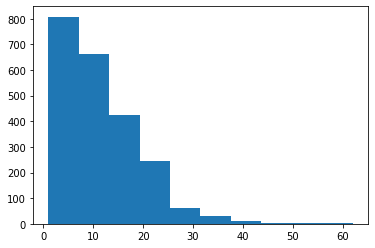

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([len(i) for i in x_train])
plt.show()

In [48]:
len(enc)

6121

In [38]:
# Because most of the reviews in the histogram above are length 35 or less, setting max_length to 35 words:
max_length = 35
x_train = sequence.pad_sequences(x_train, maxlen = max_length)
x_test = sequence.pad_sequences(x_test, maxlen = max_length)

In [ ]:
y_train

## Normalizing sentence word length with padding and unknown variables

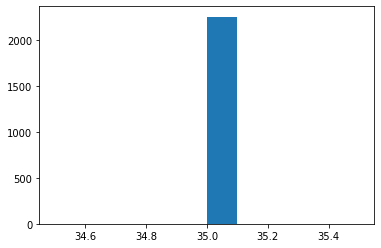

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([len(i) for i in x_train])
plt.show()
### Note that after padding, all sentences are the same length (same number of parameters)

### Encoded vector length

In [40]:
len(enc)

6049

# Neural Network Modeling:
## Simple Recurrent Neural Network / Bidirectional Simple Recurrent Neural Network
## Long Short Term Memory Network (LSTM) / Gated Recurrent Unit Network (GRU)

The below sections provide testing and validation scores for accuracy and loss applied to four different variations of the recurrent neural network model: The simple RNN, the bidirectional simple RNN, the Long Short Term Memory, and the Gated Recurrent Unit.

The bidirectional simple RNN performed slightly better than the simple RNN. The LSTM and GRU performed comparable to each other as well. Based on performance given the configurations below, the GRU should be selected over the other three models based on test and validation accuracy and loss.

In [187]:
summary_data = {
    'Model':['SimpleRNN','Bidirectional SimpleRNN','LSTM','GRU'], 
    'Accuracy (Test)':['0.96','0.95','0.96','0.94'], 
    'Accuracy (Validation)':['0.65','0.70','0.75','0.76'], 
    'Loss (Test)':['0.07','0.15','0.08','0.14'], 
    'Loss (Validation)':['1.07','0.97','0.99','0.82']}

pd.DataFrame(summary_data)

,Model,Accuracy (Test),Accuracy (Validation),Loss (Test),Loss (Validation)
0,SimpleRNN,0.96,0.65,0.07,1.07
1,Bidirectional SimpleRNN,0.95,0.70,0.15,0.97
2,LSTM,0.96,0.75,0.08,0.99
3,GRU,0.94,0.76,0.14,0.82


# Simple RNN

In [ ]:
# Setting up grid search
%%time seed = 7
numpy.random.seed(seed)
batch_size = 128
epochs = 10
model_CV = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=1)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train) 

In [144]:
embedding_vector_length = 80 # The parameter for embedding will be n*80 (below)
model1 = Sequential()
model1.add(Embedding(6121, embedding_vector_length, input_length=max_length)) # len(enc) + 1 because of errors for out-of-bounds)
model1.add(SimpleRNN(100,unroll=True, dropout=0.2)) # unroll makes this run faster
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())
#model1.fit(x_train, np.array(y_train), validation_data=(x_test, np.array(y_test)), epochs=5, batch_size=64)
model_SimpleRNN = model1.fit(x_train, np.array(y_train), validation_data=(x_test, np.array(y_test)), epochs=25, batch_size=64)

# 1255440 because 80 * len(enc) where lenght of the enc (encoded) vector is 15,693; hence, 15693 x 80 = 1,255,440

# if loss is dropping and accuracy is increasing, make sure the validation metrics are doing the same, respectively, as well.

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 35, 80)            489680    
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 100)               18100     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 507,881
Trainable params: 507,881
Non-trainable params: 0
_________________________________________________________________
None
Train on 2250 samples, validate on 750 samples
Epoch 1/25
2250/2250 [==============================] - 2s 1ms/sample - loss: 0.6906 - accuracy: 0.5307 - val_loss: 0.6867 - val_accuracy: 0.5573
Epoch 2/25
2250/2250 [==============================] - 0s 151us/sample - loss: 0.5391 - accuracy: 0.8053 - val_loss: 0.7375 - val_accuracy: 0.5360
Epoch 3/25
2250/2250 [=========

# SimpleRNN Metrics Averages
### Validation and Test: Accuracy and Loss

In [167]:
print("Average test accuracy: ", np.average(model_SimpleRNN.history['accuracy']))
print("Average validation accuracy: ", np.average(model_SimpleRNN.history['val_accuracy']))

Average test accuracy:  0.96917325
Average validation accuracy:  0.64976


In [166]:
print("Average test loss: ", np.average(model_SimpleRNN.history['loss']))
print("Average validation loss: ", np.average(model_SimpleRNN.history['val_loss']))

Average test loss:  0.06957003912732301
Average validation loss:  1.0689582870992025


# SimpleRNN Accuracy

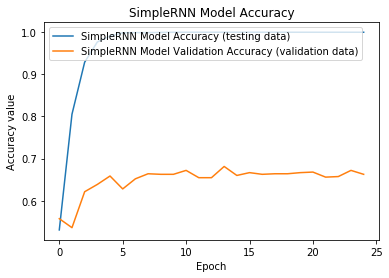

In [146]:
plt.plot(model_SimpleRNN.history['accuracy'], label='SimpleRNN Model Accuracy (testing data)')
plt.plot(model_SimpleRNN.history['val_accuracy'], label='SimpleRNN Model Validation Accuracy (validation data)')
plt.title('SimpleRNN Model Accuracy')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# SimpleRNN Loss

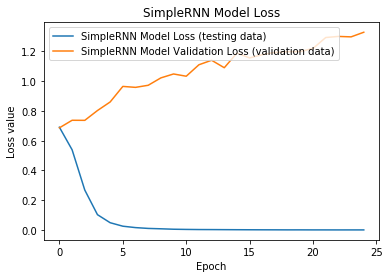

In [145]:
plt.plot(model_SimpleRNN.history['loss'], label='SimpleRNN Model Loss (testing data)')
plt.plot(model_SimpleRNN.history['val_loss'], label='SimpleRNN Model Validation Loss (validation data)')
plt.title('SimpleRNN Model Loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# Bidirectional Simple Recurrent Neural Network (SimpleRNN)

In [148]:
from tensorflow.keras.layers import Bidirectional, TimeDistributed
embedding_vector_length = 80
model5 = Sequential()
model5.add(Embedding(6121, embedding_vector_length, input_length=max_length))
# Bidirectional layer that includes dropout, which prevents over-fitting by arndomly dropping units and their connections 
# during training - also called "thinning". This is better than regularization techniques. Results are comparable.
model5.add((Bidirectional(SimpleRNN(100,return_sequences=False, dropout=0.2))))
model5.add(Dense(1, activation='sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model5.summary())
model_Bidirectional_SimpleRNN = model5.fit(x_train, np.array(y_train), validation_data=(x_test, np.array(y_test)), epochs=15, batch_size=64)
 # The parameter for embedding will be 15693*80: len(enc)*embedding_vecor_length

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 35, 80)            489680    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               36200     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 201       
Total params: 526,081
Trainable params: 526,081
Non-trainable params: 0
_________________________________________________________________
None
Train on 2250 samples, validate on 750 samples
Epoch 1/15
2250/2250 [==============================] - 3s 1ms/sample - loss: 0.6886 - accuracy: 0.5431 - val_loss: 0.6550 - val_accuracy: 0.6307
Epoch 2/15
2250/2250 [==============================] - 1s 395us/sample - loss: 0.4796 - accuracy: 0.7889 - val_loss: 0.6004 - val_accuracy: 0.6853
Epoch 3/15
2250/2250 [=========

# Bidirectional SimpleRNN Metrics Averages
### Validation and Test: Accuracy and Loss

In [164]:
print("Average test accuracy: ", np.average(model_Bidirectional_SimpleRNN.history['accuracy']))
print("Average validation accuracy: ", np.average(model_Bidirectional_SimpleRNN.history['val_accuracy']))

Average test accuracy:  0.9471704
Average validation accuracy:  0.7033777


In [165]:
print("Average test loss: ", np.average(model_Bidirectional_SimpleRNN.history['loss']))
print("Average validation loss: ", np.average(model_Bidirectional_SimpleRNN.history['val_loss']))

Average test loss:  0.10570178243638258
Average validation loss:  0.9662411064253914


# Bidirectional SimpleRNN Accuracy

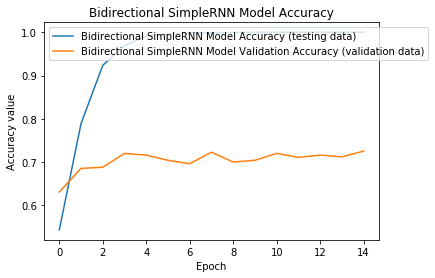

In [150]:
plt.plot(model_Bidirectional_SimpleRNN.history['accuracy'], label='Bidirectional SimpleRNN Model Accuracy (testing data)')
plt.plot(model_Bidirectional_SimpleRNN.history['val_accuracy'], label='Bidirectional SimpleRNN Model Validation Accuracy (validation data)')
plt.title('Bidirectional SimpleRNN Model Accuracy')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# Bidirectional SimpleRNN Loss

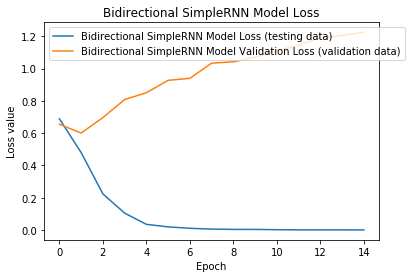

In [149]:
plt.plot(model_Bidirectional_SimpleRNN.history['loss'], label='Bidirectional SimpleRNN Model Loss (testing data)')
plt.plot(model_Bidirectional_SimpleRNN.history['val_loss'], label='Bidirectional SimpleRNN Model Validation Loss (validation data)')
plt.title('Bidirectional SimpleRNN Model Loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# Long Short Term Memory (LSTM)

In [151]:
embedding_vector_length = 80
model1 = Sequential()
model1.add(Embedding(6121, embedding_vector_length, input_length=max_length))
model1.add(LSTM(100,unroll=True, dropout=0.2)) # unroll makes this run faster
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())
model_LSTM = model1.fit(x_train, np.array(y_train), validation_data=(x_test, np.array(y_test)), epochs=25, batch_size=64)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 35, 80)            489680    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               72400     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 562,181
Trainable params: 562,181
Non-trainable params: 0
_________________________________________________________________
None
Train on 2250 samples, validate on 750 samples
Epoch 1/25
2250/2250 [==============================] - 4s 2ms/sample - loss: 0.6879 - accuracy: 0.5591 - val_loss: 0.6752 - val_accuracy: 0.5947
Epoch 2/25
2250/2250 [==============================] - 1s 224us/sample - loss: 0.5604 - accuracy: 0.7818 - val_loss: 0.5722 - val_accuracy: 0.7053
Epoch 3/25
2250/2250 [=========

# LSTM Metrics Averages
### Validation and Test: Accuracy and Loss

In [162]:
print("Average test accuracy: ", np.average(model_LSTM.history['accuracy']))
print("Average validation accuracy: ", np.average(model_LSTM.history['val_accuracy']))

Average test accuracy:  0.96426666
Average validation accuracy:  0.75360006


In [163]:
print("Average test loss: ", np.average(model_LSTM.history['loss']))
print("Average validation loss: ", np.average(model_LSTM.history['val_loss']))

Average test loss:  0.08485519747295832
Average validation loss:  0.9912008084932961


# LSTM Accuracy

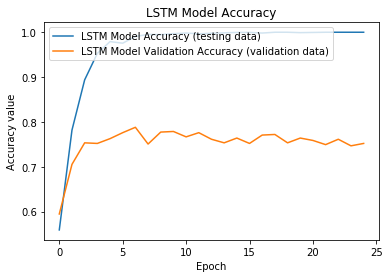

In [153]:
plt.plot(model_LSTM.history['accuracy'], label='LSTM Model Accuracy (testing data)')
plt.plot(model_LSTM.history['val_accuracy'], label='LSTM Model Validation Accuracy (validation data)')
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# LSTM Loss

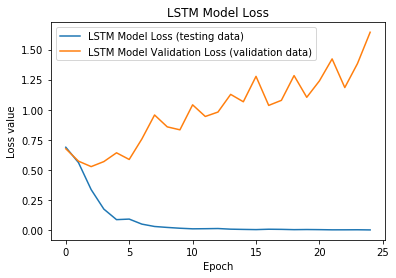

In [152]:
plt.plot(model_LSTM.history['loss'], label='LSTM Model Loss (testing data)')
plt.plot(model_LSTM.history['val_loss'], label='LSTM Model Validation Loss (validation data)')
plt.title('LSTM Model Loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# Gated Recurrent Unit (GRU)

In [155]:
embedding_vector_length = 80
model1 = Sequential()
model1.add(Embedding(6121, embedding_vector_length, input_length=max_length))
model1.add(GRU(100, unroll=True, dropout=0.2)) # unroll makes this run faster
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())
model_GRU = model1.fit(x_train, np.array(y_train), validation_data=(x_test, np.array(y_test)), epochs=25, batch_size=64, callbacks=[es, tensorboard_callback])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 35, 80)            489680    
_________________________________________________________________
gru (GRU)                    (None, 100)               54600     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 101       
Total params: 544,381
Trainable params: 544,381
Non-trainable params: 0
_________________________________________________________________
None
Train on 2250 samples, validate on 750 samples
Epoch 1/25
2250/2250 [==============================] - 8s 4ms/sample - loss: 0.6876 - accuracy: 0.5707 - val_loss: 0.6687 - val_accuracy: 0.6773
Epoch 2/25
2250/2250 [==============================] - 1s 333us/sample - loss: 0.5406 - accuracy: 0.7702 - val_loss: 0.5178 - val_accuracy: 0.7440
Epoch 3/25
2250/2250 [=========

# GRU Metrics Averages
### Validation and Test: Accuracy and Loss

In [161]:
print("Average test accuracy: ", np.average(model_GRU.history['accuracy']))
print("Average validation accuracy: ", np.average(model_GRU.history['val_accuracy']))

Average test accuracy:  0.935624
Average validation accuracy:  0.7573334


In [160]:
print("Average test loss: ", np.average(model_GRU.history['loss']))
print("Average validation loss: ", np.average(model_GRU.history['val_loss']))

Average test loss:  0.1390746725020158
Average validation loss:  0.8158446235167675


# GRU Accuracy

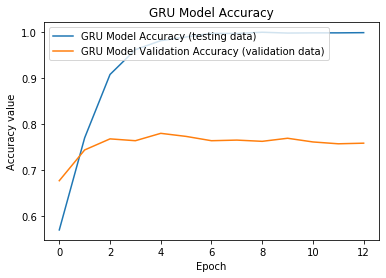

In [157]:
plt.plot(model_GRU.history['accuracy'], label='GRU Model Accuracy (testing data)')
plt.plot(model_GRU.history['val_accuracy'], label='GRU Model Validation Accuracy (validation data)')
plt.title('GRU Model Accuracy')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# GRU Loss

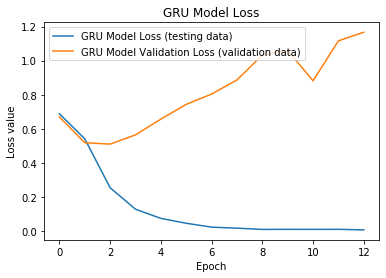

In [156]:
plt.plot(model_GRU.history['loss'], label='GRU Model Loss (testing data)')
plt.plot(model_GRU.history['val_loss'], label='GRU Model Validation Loss (validation data)')
plt.title('GRU Model Loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()